# Anomaly detection

This Jupyter Notebook will test a pre-trained network for jet images. The data used is created in examples/process_jet_images.

## Setup

### Loading data

Note: You have to change the path to the directory where your processed files are. 

In [1]:
import os
import pandas as pd

save_dir = "plotOutput" # Change this to the path to wherever you want to save the figures
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# =========== Images + jet variables ===========
# Complete DataFrame (image and all jet variables)
path_complete = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/jet_images_LAGAN_complete.pkl'
df_complete = pd.read_pickle(path_complete) 

# Complete DataFrame (image and all jet variables) for only signal jets
path_complete_signal = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/jet_images_LAGAN_complete_signal.pkl'
df_complete_signal = pd.read_pickle(path_complete_signal) 

# Complete DataFrame (image and all jet variables) for only background jets
path_complete_bg = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/jet_images_LAGAN_complete_bg.pkl'
df_complete_bg = pd.read_pickle(path_complete_bg) 

# =========== Images ===========
# Only jet images
path_img_all = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images.pkl'
df_img_all = pd.read_pickle(path_img_all) 

# Only jet images for signal jets
path_signal = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_signal.pkl'
df_signal = pd.read_pickle(path_signal) 

# Only jet images for background jets
path_bg = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_bg.pkl'
df_bg = pd.read_pickle(path_bg) 

# =========== From network ===========
#path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-300-100-300-625/val_bg/bg_all_img_625-300-100-300-625_output.pkl'
#path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-625-625-625-625/val_bg/bg_all_img_625-625-625-625-625_output.pkl'
#path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-625-625-625-625/val_signal/bg_all_img_625-625-625-625-625_output_signal.pkl'
path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-300-100-300-625/val_signal/bg_all_img_625-300-100-300-625_output_signal.pkl'
df_output = pd.read_pickle(path_output)

### Preparing data for network

In [2]:
import os
import pandas as pd

save_dir = "plotOutput" # Change this to the path to wherever you want to save the figures
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Only jet images for signal jets
path_signal = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_signal.pkl'
df_signal = pd.read_pickle(path_signal) 
path_bg_test = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_bg_test.pkl'
df_bg_test = pd.read_pickle(path_bg_test) 

In [3]:
# Separate the DataFrame into three sets.
split1 = round(0.7*len(df))
split2 = round(0.2*len(df))

train = df[:split1] # 70 %
valid = df[split1:split1+split2] # 20 %
test = df[split1+split2:] # 10 %

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

### Setting up the network

In [5]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [6]:
class AE_3D_200_LeakyReLU_test(nn.Module):
    def __init__(self, n_features=625):
        super(AE_3D_200_LeakyReLU_test, self).__init__()
        self.en1 = nn.Linear(n_features, 300)
        self.en2 = nn.Linear(300, 100)
        self.de1 = nn.Linear(100, 300)
        self.de2 = nn.Linear(300, n_features)
        #self.en1 = nn.Linear(n_features, 625)
        #self.en2 = nn.Linear(625, 625)
        #self.de1 = nn.Linear(625, 625)
        #self.de2 = nn.Linear(625, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en2(self.tanh(self.en1(x)))

    def decode(self, x):
        return self.de2(self.tanh(self.de1(self.tanh(x))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'text'

model = AE_3D_200_LeakyReLU_test()
model.to('cpu')

AE_3D_200_LeakyReLU_test(
  (en1): Linear(in_features=625, out_features=300, bias=True)
  (en2): Linear(in_features=300, out_features=100, bias=True)
  (de1): Linear(in_features=100, out_features=300, bias=True)
  (de2): Linear(in_features=300, out_features=625, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [7]:
from fastai.metrics import mse

loss_func = nn.MSELoss(reduction='none')
wd = 1e-6

learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func)

### Loading the pre-trained network

In [8]:
#learn.load('bg_all_img_625-625-625-625')
learn.load('bg_all_img_625-300-100-300-625')

## Anomaly detection

### Calculating the anomaly score

In [10]:
#from: https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

test_preds, test_targs = learn.get_preds(dl=test_dl)
mse = np.zeros(len(test_targs))
for i in range(len(test_targs)):
    mse[i] = loss_func(test_preds[i],test_targs[i])

### Classification

In [13]:
classification = np.zeros(len(image_MSE))
thresholds = np.linspace(min(image_MSE), max(image_MSE),10)
accuracy = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds)) # True positive
TN = np.zeros(len(thresholds)) # True negative
FP = np.zeros(len(thresholds)) # False positive
FN = np.zeros(len(thresholds)) # False negative

for cidx in range(len(thresholds)):
    for i in range(len(image_MSE)):
        if image_MSE[i] > thresholds[cidx]:
            classification[i] = 1 #Classified as "anomalous"
        else:
            classification[i] = 0 #Classified as "normal"
        
        # For confusion matrix
        if classification[i] == 1 and df_complete['signal/background'][i] == 1: # Predicted anomaly and is anomaly
            TP[cidx] = TP[cidx] + 1
        elif classification[i] == 1 and df_complete['signal/background'][i] == 0: # Predicted anomaly but is normal
            FP[cidx] = FP[cidx] + 1
        elif classification[i] == 0 and df_complete['signal/background'][i] == 0: # Predicted normal and is normal
            TN[cidx] = FN[cidx] + 1
        elif classification[i] == 0 and df_complete['signal/background'][i] == 1: # Predicted normal but is anomaly
            FN[cidx] = FN[cidx] + 1
            
    accuracy[cidx] = (TP[cidx] + TN[cidx])/(TP[cidx]+FN[cidx]+TN[cidx]+FP[cidx])

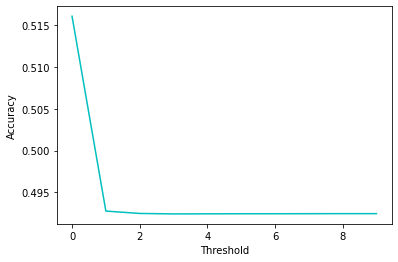

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(accuracy, color='c')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

### Confusion matrix

In [19]:
def confusion_matrix(TP,TN,FP,FN):
    return np.array([[TP, FN], [FP, TN]])

def plot_confusion_matrix(cm, thresh):
    
    import itertools
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    # Plots background and colorbar
    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    
    # Sets ticks with certain labels
    target_names = ['anomaly','normal']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    
    # Plots numbers
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 100 else "black")
        #color="white" if cm[i, j] > thresh else "black")

    # Labels
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 13)
    plt.xlabel('Predicted label', fontsize = 13)
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

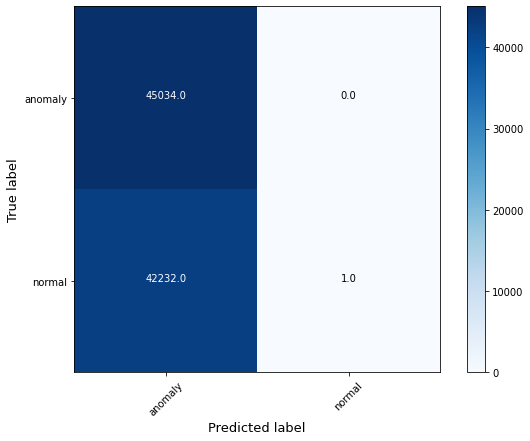

In [20]:
idx = np.argmax(accuracy) # Index of threshold with best accuracy
plot_confusion_matrix(cm = confusion_matrix(TP[idx],TN[idx],FP[idx],FN[idx]), thresh = thresholds[idx])